In [1]:
from pathlib import Path

import os
import torch
import albumentations as A

from tracenet.datasets import CellDetection, FilamentDetection
from tracenet import get_train_transform, get_valid_transform
from tracenet.utils.plot import plot_results
from tracenet.models.detr import build_model

In [2]:
# data = 'cell'
# data_dir = 'celldata'
# model_path = rf'models/cells/checkpoint.pth'
# maxsize = 1024

data = 'mt'
data_dir = 'mtdata'
model_path = rf'models/mt/checkpoint.pth'
maxsize = 630

train_dir = 'train'
val_dir = 'val'

In [3]:
path = Path(data_dir)
if data == 'cell':
    ds_train, ds_val = [
        CellDetection(
            path / 'maxprojections', path / rf'bboxes_for_cell_detection_{dset}.csv', 
            transforms=transform(bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
            maxsize=maxsize
        ) for dset, transform in zip([train_dir, val_dir], [get_train_transform, get_valid_transform])]
else:
    ds = []
    for dset, transform in zip([train_dir, val_dir], [get_train_transform, get_valid_transform]): 
        files = os.listdir(path / dset / 'img')
        files.sort()
        ds.append(
            FilamentDetection(
                [path / dset / 'img' / fn for fn in files],
                [path / dset / 'gt' / fn.replace('.tif', '.csv') for fn in files],
                transforms=transform(keypoint_params=A.KeypointParams(format='xy', 
                                                                      label_fields=['point_labels'], 
                                                                      remove_invisible=False, 
                                                                      angle_in_degrees=True)),
                maxsize=maxsize
            )
        )
    ds_train, ds_val = ds

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, 
                                       batch_size=2, num_workers=2)
dl_val = torch.utils.data.DataLoader(ds_val, shuffle=False, 
                                     batch_size=2, num_workers=2)

In [4]:
imgs, targets = next(iter(dl_train))

/research/sharedresources/cbi/common/Anna/codes/trace-net/tracenet/datasets/filament.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  boxes = torch.as_tensor(boxes, dtype=torch.float32)
/research/sharedresources/cbi/common/Anna/codes/trace-net/tracenet/datasets/filament.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  boxes = torch.as_tensor(boxes, dtype=torch.float32)


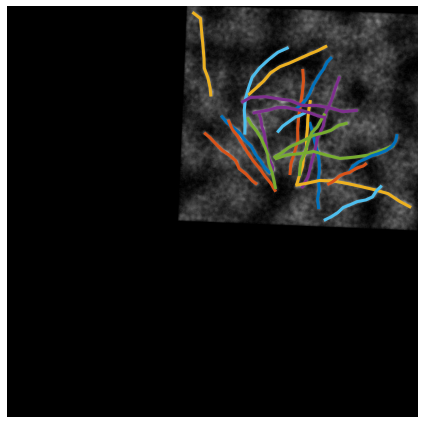

In [5]:
ind = 1
im = plot_results(imgs[ind], targets['boxes'][ind])

## Prediction

In [6]:
model = build_model(n_classes=1, n_points=10 if data=='mt' else 2, 
                    pretrained=True, 
                    # state_dict_path=model_path
                   ).eval();

Using cache found in /home/amedyukh/.cache/torch/hub/facebookresearch_detr_main


/home/amedyukh/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


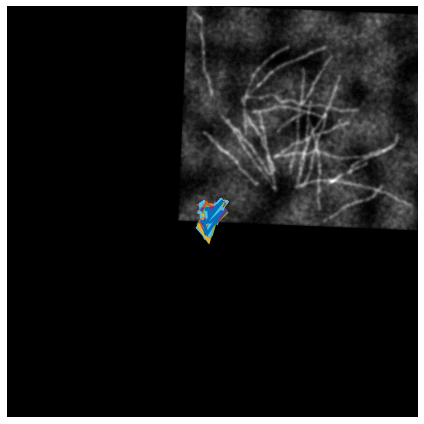

In [7]:
# propagate through the model
with torch.no_grad():
    outputs = model(imgs)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[ind, :, :-1]
keep = probas.max(-1).values > 0.7
plot_results(imgs[ind], outputs['pred_boxes'][ind, keep], probas[keep])

## Test the Loss

In [8]:
outputs = model(imgs)

In [9]:
from tracenet.models.matcher import HungarianMatcher
from tracenet.models.criterion import Criterion

In [10]:
matcher = HungarianMatcher()

In [11]:
loss = Criterion(1, matcher, 
                 losses=['labels', 'boxes', 'cardinality'])

In [12]:
loss(outputs, targets)

{'loss_ce': tensor(0.5587, grad_fn=<NllLoss2DBackward0>),
 'loss_bbox': tensor(4.3170, grad_fn=<DivBackward0>),
 'cardinality_error': tensor(77.)}